In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import gym
import matplotlib.pyplot as plt
from numpy.linalg import LinAlgError


import sys
sys.path.append('./asebo/')
from optimizers import Adam
from worker import worker, get_policy
from es import ES

In [2]:
def F(theta):
    if theta.ndim == 1:
        theta = np.expand_dims(theta, 0)
    return -np.sum((theta - 0.5) ** 2, axis=tuple(range(theta.ndim)[1:]))


def Gradient_LP(y, epsilons):
    """
    y = (F(theta + sigma*epsilons) - F(theta)) / sigma
    epsilons: the perturbations with UNIT VARIANCE
    """
    n, d = epsilons.shape
    
    var_z = cp.Variable(n)
    var_g = cp.Variable(d)
    obj = sum(var_z)
    constraints = [var_z >= y - epsilons @ var_g,
                   var_z >= -y + epsilons @ var_g]
    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve(solver=cp.GLPK, eps=1e-6, glpk={'msg_lev': 'GLP_MSG_OFF'})
    if prob.status == 'optimal':
        return var_g.value
    return None

def Hessian_LP(y, epsilons):
    """
    y = (F(theta + sigma*epsilons) + F(theta - sigma*epsilons) - 2*F(theta)) / (sigma**2)
    epsilons: the perturbations with UNIT VARIANCE
    """
    n, d = epsilons.shape
    
    
    X = np.zeros((n, d*(d+1)//2))
    idx = 0
    for j in range(d):
        X[:,idx] = epsilons[:,j]**2
        idx += 1
        if j == d-1:
            break
        X[:,idx:idx+d-j-1] = 2 * epsilons[:,j:j+1] * epsilons[:,j+1:]
        idx += d-j-1
#         X[:,j*(j+1)//2:(j+1)*(j+2)//2-1] = 2 * epsilons[:,j:j+1] * epsilons[:,:j]
#         X[:,(j+1)*(j+2)//2-1] = epsilons[:,j]**2
    
    var_z = cp.Variable(n)
    var_H = cp.Variable(d*(d+1)//2)
    
    obj = sum(var_z)
    
    constraints = []
    for i in range(n):
        constraints += [var_z[i] >= y[i] - X[i] @ var_H]
        constraints += [var_z[i] >= - y[i] + X[i] @ var_H]
    
    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve(solver=cp.GLPK, eps=1e-6, glpk={'msg_lev': 'GLP_MSG_OFF'})

    if prob.status == 'optimal':
        H = np.zeros((d,d))
        idx = 0
        for j in range(d):
            H[j,j:] = var_H[idx:idx+d-j].value
            H[j:,j] = var_H[idx:idx+d-j].value
            idx += d-j
#             H[j,0:j+1] = var_H[j*(j+1)//2:(j+1)*(j+2)//2].value
#             H[1:j+1,j] = H[j,1:j+1]
        return H
    return None


def get_dct_mtx(d):
    # DCT matrix
    # unitary, symmetric and real
    # Orthonormal eigenbasis for structured H
    n = 2*d
    i_idx = np.array([range(n//2 )])
    idx = 2 * np.transpose(i_idx) @ i_idx
    dct_mtx = np.cos(idx*np.pi / n) * 2 / np.sqrt(d)
    dct_mtx[0,0] = 1
    dct_mtx[0,d-1] = 1
    dct_mtx[d-1,0] = 1
    dct_mtx[d-1,d-1] = (-1)**(d)
    return dct_mtx
def Hessian_LP_structured(y, epsilons):
    """
    y = (F(theta + sigma * epsilons) + F(theta - sigma * epsilons) - 2 * F(theta)) / (sigma ** 2)
    """
    # LP formulation to estimate Hessian
    # Minimizing over the space of matrices of the form
    # shown in the example 7 & 8 in the reference
    # [MATRICES DIAGONALIZED BY THE DISCRETECOSINE AND DISCRETE SINE TRANSFORMS]
    
    n, d = epsilons.shape
    
    # Define and solve the LP for Hessian here
    
    
    var_z = cp.Variable(n)
    var_H_diag = cp.Variable(d)
    
    # Lower triangular mtx H
    dct_mtx = get_dct_mtx(d)
    obj = sum(var_z)
    
    constraints = []
    for i in range(n):
        Uv = epsilons[i:i+1,:] @ dct_mtx
        Uv_sq = Uv * Uv
        constraints += [var_z[i] >= y[i] - Uv_sq @ var_H_diag]
        constraints += [var_z[i] >= - y[i] + Uv_sq @ var_H_diag]
    for i in range(d):
        constraints += [var_H_diag[i] <= 0]
        
    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve(solver=cp.GLPK, eps=1e-6, glpk={'msg_lev': 'GLP_MSG_OFF'})
    
    # 
    if prob.status == 'optimal':
        return dct_mtx @ np.diag(var_H_diag.value) @ np.transpose(dct_mtx)
    
    return None


In [3]:
def aggregate_rollouts_hessianES(master, A, params, n_samples):
    
    all_rollouts = np.zeros([n_samples+1, 2])

    timesteps = 0
    
    # F(theta + sigma*epsilons), and F(theta - sigma*epsilons)
    assert A.shape[0] == n_samples+1
    for i in range(n_samples+1):
        w = worker(params, master, A, i)
        all_rollouts[i] = np.reshape(w.do_rollouts(), 2)
        timesteps += w.timesteps

    all_rollouts = (all_rollouts - np.mean(all_rollouts)) / (np.std(all_rollouts)  + 1e-8)
    
    # (F(theta + sigma*epsilons) - F(theta)) / sigma
    gradient_y = np.array(all_rollouts[:-1, 0] - sum(all_rollouts[-1])/2) / params["sigma"]
    # (F(theta + sigma*epsilons) + F(theta - sigma*epsilons) - 2*F(theta)) / (sigma**2)
    hessian_y = np.array(all_rollouts[:-1, 0] + all_rollouts[:-1, 1] - sum(all_rollouts[-1])) / (params["sigma"]**2)
    return(gradient_y, hessian_y, timesteps)

def HessianES(params, master):
        
#     if params['n_iter'] >= params['k']:
#         pca = PCA()
#         pca_fit = pca.fit(G)
#         var_exp = pca_fit.explained_variance_ratio_
#         var_exp = np.cumsum(var_exp)
#         n_samples = np.argmax(var_exp > params['threshold']) + 1
#         if n_samples < params['min']:
#             n_samples = params['min']
#         U = pca_fit.components_[:n_samples]
#         UUT = np.matmul(U.T, U)
#         U_ort = pca_fit.components_[n_samples:]
#         UUT_ort = np.matmul(U_ort.T, U_ort)
#         alpha = params['alpha']
#         if params['n_iter'] == params['k']:
#             n_samples = params['num_sensings']
#     else:
#         UUT = np.zeros([master.N, master.N])
#         alpha = 1
#         n_samples = params['num_sensings']
    
    n_samples = params['num_sensings']
    
#     np.random.seed(None)
    cov = np.identity(master.N)*(params["sigma"]**2)
    mu = np.repeat(0, master.N)
    A = np.random.multivariate_normal(mu, cov, n_samples)
#     A /= np.linalg.norm(A, axis =-1)[:, np.newaxis]
    A = np.vstack([A, mu]) # Adding a reference evaluation
        
    gradient_y, hessian_y, timesteps = aggregate_rollouts_hessianES(master, A, params, n_samples)
    
    g = Gradient_LP(gradient_y, A[:-1, :]/params["sigma"])
#     H = Hessian_LP(hessian_y, A[:-1, :]/params["sigma"])#-0.1*np.identity(master.N)
    H = Hessian_LP_structured(hessian_y, A[:-1, :]/params["sigma"]) - 0.1*np.identity(master.N)
#     H = -np.identity(len(g))
    try:
        Hinv = True
        update_direction = -np.linalg.inv(H)@g
    except LinAlgError:
        Hinv = False
        update_direction = g
#     if params['n_iter'] >= params['k']:
#         params['alpha'] = np.linalg.norm(np.dot(g, UUT_ort))/np.linalg.norm(np.dot(g, UUT))
    
    return(update_direction, n_samples, timesteps, Hinv)

## Manuel Tests

In [5]:
params = {
'env_name': 'InvertedPendulum-v2',
'steps':1000,
'h_dim':32,
'start':0,
'max_iter':1000,
'seed':0,

'k':140,
'num_sensings':100,#100
'log':0,
'threshold':0.995,
'decay':0.99,
'learning_rate':0.01,#0.05
'filename':'',
'policy':'Linear', # Linear or Toeplitz

'shift':0,
'min':10,
'sigma':0.1
}

params['dir'] = params['env_name'] + params['policy'] + '_h' + str(params['h_dim']) + '_lr' + str(params['learning_rate']) + '_num_sensings' + str(params['num_sensings']) +'_' + params['filename']

# if not(os.path.exists('data/'+params['dir'])):
#     os.makedirs('data/'+params['dir'])
# os.chdir('data/'+params['dir'])

In [37]:
env = gym.make(params['env_name'])
params['ob_dim'] = env.observation_space.shape[0]
params['ac_dim'] = env.action_space.shape[0]

m = 0
v = 0

params['k'] += -1
params['alpha'] = 1

params['zeros'] = False
master = get_policy(params)

if params['log']:
    params['num_sensings'] = 4 + int(3 * np.log(master.N))

if params['k'] > master.N:
    params['k'] = master.N

n_eps = 0
n_iter = 1
ts_cumulative = 0
ts = []
rollouts = []
rewards = []
samples = []
alphas = []
G = [] # Don't need this for HessianES
Hinv_success = 0

n_samples = params['num_sensings']
np.random.seed(None)
cov = np.identity(master.N)*(params["sigma"]**2)
mu = np.repeat(0, master.N)
A = np.random.multivariate_normal(mu, cov, n_samples)
A /= np.linalg.norm(A, axis =-1)[:, np.newaxis]
A = np.vstack([A, mu]) # Adding a reference evaluation

gradient_y, hessian_y, timesteps = aggregate_rollouts_hessianES(master, A, params, n_samples)

In [38]:
A.shape

(101, 4)

In [39]:
%%time
g = Gradient_LP(gradient_y, A[:-1, :]/params["sigma"])

CPU times: user 31.7 ms, sys: 1.44 ms, total: 33.2 ms
Wall time: 32.2 ms


In [40]:
%%time
Hstruc = Hessian_LP_structured(hessian_y, A[:-1, :]/params["sigma"])

CPU times: user 320 ms, sys: 2.23 ms, total: 322 ms
Wall time: 321 ms


In [41]:
Hstruc

array([[-0.66486936, -0.0687222 ,  0.32419788, -0.21242544],
       [-0.0687222 , -0.17033574, -0.12824603, -0.0687222 ],
       [ 0.32419788, -0.12824603, -0.58068995, -0.12824603],
       [-0.21242544, -0.0687222 , -0.12824603, -0.21242544]])

In [42]:
np.linalg.eig(Hstruc)

(array([-9.58700168e-01, -5.53014222e-01, -5.54494605e-17, -1.16606096e-01]),
 array([[ 0.76786867,  0.42437387,  0.47984149,  0.00605527],
        [-0.02631077,  0.37801163, -0.28108464, -0.88170651],
        [-0.63093662,  0.59732751,  0.47984149,  0.12194659],
        [ 0.10772386,  0.56587443, -0.67859834,  0.45572578]]))

In [43]:
%%time
H = Hessian_LP(hessian_y, A[:-1, :]/params["sigma"])

CPU times: user 260 ms, sys: 2.42 ms, total: 263 ms
Wall time: 262 ms


In [44]:
H

array([[-0.41973596, -0.16232083, -0.14704545, -0.76977776],
       [-0.16232083, -0.14212783, -0.26579366,  0.57871458],
       [-0.14704545, -0.26579366, -1.56517797, -0.1941108 ],
       [-0.76977776,  0.57871458, -0.1941108 ,  1.35151683]])

In [45]:
np.linalg.eig(H)

(array([ 1.83432969, -1.65323722, -0.6841841 , -0.2724333 ]),
 array([[ 0.32355209, -0.18565394,  0.8819279 , -0.28818369],
        [-0.29714026, -0.15955991, -0.2234091 , -0.91451445],
        [ 0.06041598, -0.96632893, -0.16382964,  0.1889925 ],
        [-0.89631   , -0.0792569 ,  0.38138091,  0.21188516]]))

## Training

In [ ]:
# def run_hessianES(params):

env = gym.make(params['env_name'])
params['ob_dim'] = env.observation_space.shape[0]
params['ac_dim'] = env.action_space.shape[0]

m = 0
v = 0

params['k'] += -1
params['alpha'] = 1

params['zeros'] = False
master = get_policy(params)

if params['log']:
    params['num_sensings'] = 4 + int(3 * np.log(master.N))

if params['k'] > master.N:
    params['k'] = master.N

n_eps = 0
n_iter = 1
ts_cumulative = 0
ts = []
rollouts = []
rewards = []
samples = []
alphas = []
G = [] # Don't need this for HessianES
Hinv_success = 0
while n_iter < params['max_iter']:

    params['n_iter'] = n_iter
    gradient, n_samples, timesteps, Hinv = HessianES(params, master)
    Hinv_success += Hinv
#     print(Hinv)
#     gradient, n_samples, timesteps = ES(params, master, G)
    
    ts_cumulative += timesteps
    ts.append(ts_cumulative)
    alphas.append(params['alpha'])

    if n_iter == 1:
        G = np.array(gradient)
    else:
        G *= params['decay']
        G = np.vstack([G, gradient])
    n_eps += 2 * n_samples
    rollouts.append(n_eps)
#     gradient /= (np.linalg.norm(gradient) / master.N + 1e-8)

#     update, m, v = Adam(gradient, m, v, params['learning_rate'], n_iter)
    update = params['learning_rate']*gradient

    master.update(update)
    test_policy = worker(params, master, np.zeros([1, master.N]), 0)
    reward = test_policy.rollout(train=False)
    rewards.append(reward)
    samples.append(n_samples)

    print('Iteration: %s, Rollouts: %s, Reward: %s, Alpha: %s, Samples: %s' %(n_iter, n_eps, reward, params['alpha'], n_samples))
    n_iter += 1

    out = pd.DataFrame({'Rollouts': rollouts, 'Reward': rewards, 'Samples': samples, 'Timesteps': ts, 'Alpha': alphas})
    out.to_csv('HessianES_Seed%s.csv' %(params['seed']), index=False)     

Iteration: 1, Rollouts: 200, Reward: 35.0, Alpha: 1, Samples: 100


In [49]:
np.save("./data/{}_hessian.npy".format(params['dir']), master.params)
np.save("./data/{}_hessian_ts.npy".format(params['dir']), ts)
np.save("./data/{}_hessian_rs.npy".format(params['dir']), rewards)




In [11]:
np.quantile(H.flatten(), 0.98)

0.6297623255517226

In [55]:
asebo_ts = np.load("./data/InvertedPendulum-v2Toeplitz_h32_lr0.05_k140__asebo_ts.npy")
asebo_rewards = np.load("./data/InvertedPendulum-v2Toeplitz_h32_lr0.05_k140__asebo_rs.npy")

lpgrad_ts = np.load("./data/InvertedPendulum-v2Linear_h32_lr0.05_num_sensings100__LP_ts.npy")
lpgrad_rewards = np.load("./data/InvertedPendulum-v2Linear_h32_lr0.05_num_sensings100__LP_rs.npy")



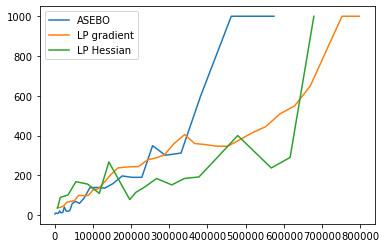

In [56]:
plt.plot(asebo_ts, asebo_rewards, label="ASEBO")
plt.plot(lpgrad_ts, lpgrad_rewards, label="LP gradient")
plt.plot(ts, rewards, label="LP Hessian")
plt.legend()


# Testing

In [18]:
!open .

In [ ]:
# master = get_policy(params)
# master.params=np.load("./data/{}_hessian.npy".format(params['dir']))
test_policy = worker(params, master, np.zeros([1, master.N]), 0)


In [ ]:
from gym.wrappers import Monitor
env = Monitor(gym.make(params['env_name']), './video', force=True)
env._max_episode_steps = params['steps']

In [ ]:
def play(env, worker):
    state = env.reset()
    while 1:
        action = worker.policy.evaluate(state)
        action = np.clip(action, worker.env.action_space.low[0], worker.env.action_space.high[0])
        action = action.reshape(len(action), )
        state, reward, done, info = env.step(action)
        env.render()
        if done: 
            break

In [ ]:
play(env, test_policy)

In [16]:
len(ts)

61

In [12]:
params['dir']

'HalfCheetah-v2Linear_h32_lr0.05_num_sensings250_'

In [9]:
np.save("./data/{}_hessian_ts.npy".format(params['dir']), ts)
np.save("./data/{}_hessian_rs.npy".format(params['dir']), rewards)

In [ ]:
sigma = 0.05
# np.random.seed(0)
# theta = np.random.uniform(-5,5,5)
theta = 0.0 * np.ones(5)
n = 100
d = len(theta)

print('theta:')
print(theta)
epsilons = np.random.multivariate_normal(mean = np.zeros(d), cov = np.identity(d), size = n)

g = Gradient_LP(theta, sigma, epsilons)
print('gradient:')
print(g)

H = Hessian_LP(theta, sigma, epsilons)
print('Hessian:')
print(H)

In [11]:
!open .
